### Overview

Similar to the spam/ham classification exercise, the goal of this notebook is to use a supervised classification algorithm to build a model that is suitable for predicting whether attorneys need to act on a certain docket text. What was provided was the 600+ docket texts with labeled targets. Even though this is a small dataset to work with, this can be a good starting point. Steps to build a supervised classificaiton model:

1. Extract dataset from excel. Dataset contains cleaned texts and their labels. Note that NLP is not necessary as the dataset contains cleaned docket texts already.
2. Compare modeling results by performing cross validation (GridsearchCV) and optimizing the model. Remember to do validation. 
3. Save model for use in Test scenario.

### Basic Necessities

In [50]:
import pandas as pd
import numpy as np
from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from wordcloud import WordCloud

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Import Data

In [63]:
data = pd.read_excel(r'E:\WinUser\Documents\Python Code\AI Paralegal\docket_texts\Train\DT\New Topics - Classification -5.27.2018.xlsx')
data.drop('DT Topics', axis = 1, inplace = True)
data.head()

,Original Docket Text,Removed unnecessary POS & vocab,Removed unnecessary POS & vocab DT,Apply Trigram Phrase Model,New Topocs,Action [Y/N],If Y
0,(REDACTED) RULE 56.1 STATEMENT. Document filed...,"['rule .', 'document file .']","['rule .', 'document file .']","['rule .', 'document file .']",System Msg,N,NaN
1,***DELETED DOCUMENT. Deleted document number 1...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",System Msg,N,NaN
2,***DELETED DOCUMENT. Deleted document number 2...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",System Msg,N,NaN
3,***NOTE TO ATTORNEY OF NON-ECF CASE ERROR. Not...,"['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...",System Msg,N,NaN
4,***NOTE TO ATTORNEY TO RE-FILE DOCUMENT - NON-...,"['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...",System Msg,N,NaN


In [64]:
#some info about the training dataset
print(data['New Topocs'].unique())
print(data['Action [Y/N]'].unique())
print(data['If Y'].unique())
print(data['Action [Y/N]'].value_counts())

['System Msg' 'Summary Judgment Filing' 'Affidavit' "Court's Response"
 'Letter to Court' 'Application' "Court's Order" "Court's Order "
 'Trial Filing' 'Brief' 'Motion' 'Discovery' 'Discover' nan
 'Default Judgment' 'Transcript']
['N' nan 'Y']
[nan 'Triage']
Y    391
N    231
Name: Action [Y/N], dtype: int64


In [65]:
data.rename(columns = {'Apply Trigram Phrase Model': 'feature'}, inplace = True)
data.feature = data.feature.apply(lambda x: ' '.join(literal_eval(x)))
data['label'] = data['Action [Y/N]'].apply(lambda x: 1 if x == 'Y' else 0 )
print(data['label'].value_counts())

1    391
0    233
Name: label, dtype: int64


### Define Training data

In [66]:
Xtrain = data.feature
ytrain = data.label

### Text Transformation. A little different from previous attempts...

In [68]:
vect = CountVectorizer() #Convert a collection of text documents to a matrix of token counts
vect.fit(Xtrain)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [69]:
print(len(vect.get_feature_names()))

940


In [70]:
#transform the train and test data into vectors, according to countvectorizer results
Xtrain_df = vect.transform(Xtrain)

 ### Visualisations ... whynot?

In [71]:
action = data[data.label == 1]['feature']
noaction = data[data.label == 0]['feature']

In [72]:
%%time
action_words = ''
noaction_words = ''

for val in action:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        action_words = action_words + words + ' '
        
for val in noaction:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        noaction_words = noaction_words + words + ' '


Wall time: 220 ms


In [73]:
# Generate a word cloud image
action_wordcloud = WordCloud(width = 600, height = 400).generate(action_words)
noaction_wordcloud = WordCloud(width = 600, height = 400).generate(noaction_words)

In [76]:
Counter(action_words.split()).most_common(10)

[('.', 749),
 ('file', 466),
 ('order', 280),
 ('motion', 182),
 ('document', 168),
 ('rule', 88),
 ('complaint', 72),
 ('support', 63),
 ('letter_address', 63),
 ('affidavit', 61)]

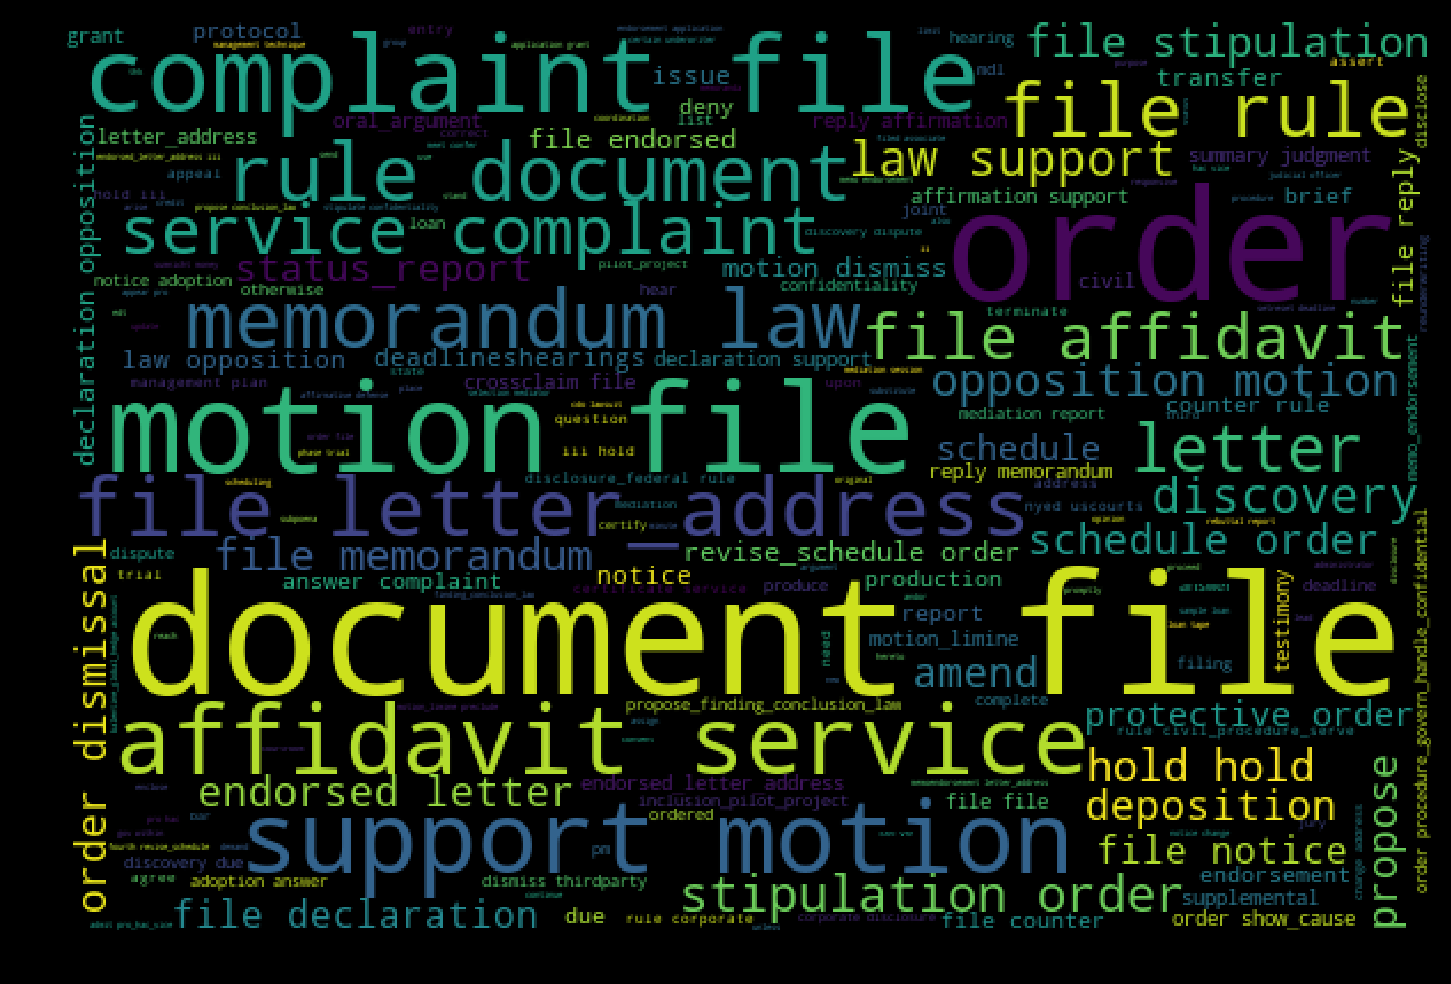

In [78]:
#Action Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(action_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

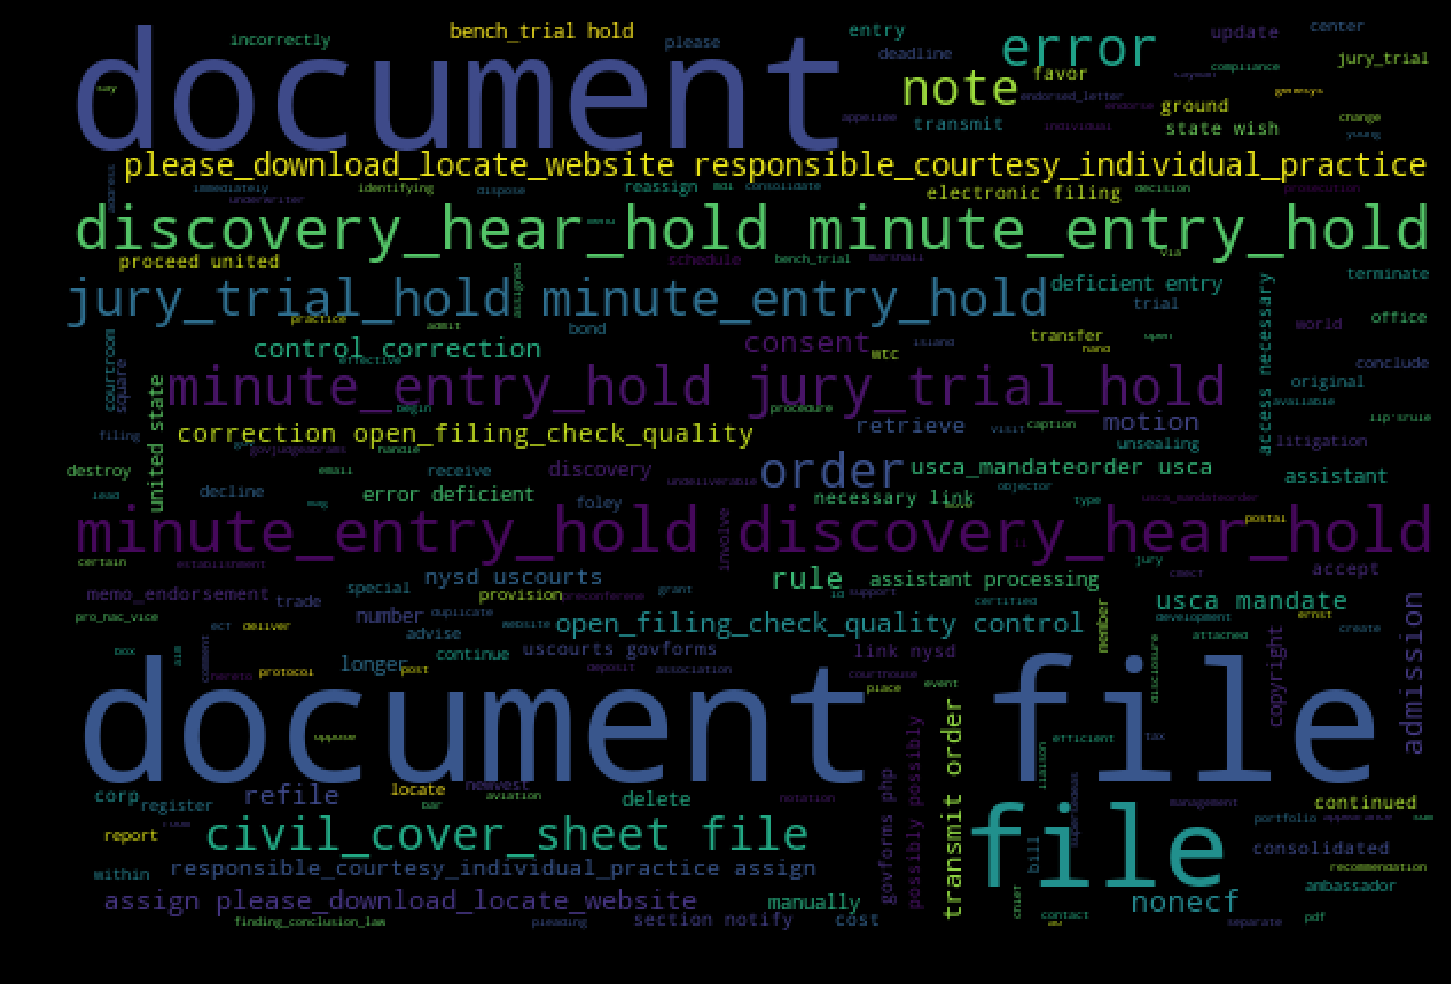

In [79]:
#No-Action Spam Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(noaction_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Machine Learning models - Default Hyperparameters

### Multinomial Naive Bayes

In [53]:
prediction = dict()
accuracy_scores = dict()

In [54]:
MNB = MultinomialNB()
MNB.fit(X_train_df, y_train)
prediction['MNB'] = MNB.predict(X_test_df)

In [55]:
MNB_treated = MultinomialNB()
MNB_treated.fit(X_train_treated_df, y_train)
prediction['MNB treated'] = MNB_treated.predict(X_test_treated_df)

In [57]:
accuracy_scores['MNB'] = accuracy_score(y_test, prediction['MNB'])
accuracy_scores['MNB treated'] = accuracy_score(y_test, prediction['MNB treated'])

### Logistic Regression

In [58]:
LR = LogisticRegression()
LR.fit(X_train_df, y_train)
prediction['LR'] = LR.predict(X_test_df)

In [59]:
LR_treated = LogisticRegression()
LR_treated.fit(X_train_treated_df, y_train)
prediction['LR treated'] = LR_treated.predict(X_test_treated_df)

In [60]:
accuracy_scores['LR'] = accuracy_score(y_test, prediction['LR'])
accuracy_scores['LR treated'] = accuracy_score(y_test, prediction['LR treated'])

### KNN Classifier

In [61]:
KNNC = KNeighborsClassifier(n_neighbors = 5)
KNNC.fit(X_train_df, y_train)
prediction['KNNC'] = KNNC.predict(X_test_df)

In [62]:
KNNC_treated = KNeighborsClassifier(n_neighbors = 5)
KNNC_treated.fit(X_train_treated_df, y_train)
prediction['KNNC treated'] = KNNC_treated.predict(X_test_treated_df)

In [63]:
accuracy_scores['KNNC'] = accuracy_score(y_test, prediction['KNNC'])
accuracy_scores['KNNC treated'] = accuracy_score(y_test, prediction['KNNC treated'])

### Ensemble Classifier 1

In [64]:
RFC = RandomForestClassifier()
RFC.fit(X_train_df, y_train)
prediction['RFC'] = RFC.predict(X_test_df)

In [70]:
RFC_treated = RandomForestClassifier()
RFC_treated.fit(X_train_treated_df, y_train)
prediction['RFC treated'] = RFC_treated.predict(X_test_treated_df)

In [71]:
accuracy_scores['RFC'] = accuracy_score(y_test, prediction['RFC'])
accuracy_scores['RFC treated'] = accuracy_score(y_test, prediction['RFC treated'])

### Ensemble Classifier 2

In [72]:
ABC = AdaBoostClassifier()
ABC.fit(X_train_df, y_train)
prediction['ABC'] = ABC.predict(X_test_df)

In [73]:
ABC_treated = AdaBoostClassifier()
ABC_treated.fit(X_train_treated_df, y_train)
prediction['ABC treated'] = ABC_treated.predict(X_test_treated_df)

In [74]:
accuracy_scores['ABC'] = accuracy_score(y_test, prediction['ABC'])
accuracy_scores['ABC treated'] = accuracy_score(y_test, prediction['ABC treated'])

In [76]:
accuracy_scores # for some reason the untreated ones performs better? currenlty, the highest score is MNB at 98.8%

{'ABC': 0.967713004484305,
 'ABC treated': 0.9668161434977578,
 'KNNC': 0.9121076233183857,
 'KNNC treated': 0.9049327354260089,
 'LR': 0.9802690582959641,
 'LR treated': 0.979372197309417,
 'MNB': 0.9883408071748879,
 'MNB treated': 0.9865470852017937,
 'RFC': 0.9695067264573991,
 'RFC treated': 0.968609865470852}

### Parameter Tuning using GridSearchCV
lets see how much we can improve each modeling algo

In [179]:
alpha_range = [0.01, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2, 0.9, 1, 1.1, 1.2, 1.4, 1.5, 1.6, 1.7, 
               2, 2.1, 2.15, 2.2, 2.25, 2.3, 2.4, 2.5, 2.6, 3, 5, 10]
fit_prior_range = [True, False]
param_grid = dict(fit_prior = fit_prior_range, alpha = alpha_range)
print(param_grid)

MNB = MultinomialNB()
grid_treated = GridSearchCV(MNB, param_grid)
grid_treated.fit(X_train_treated_df, y_train)


MNB = MultinomialNB()
grid = GridSearchCV(MNB, param_grid)
grid.fit(X_train_df, y_train)

{'alpha': [0.01, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2, 0.9, 1, 1.1, 1.2, 1.4, 1.5, 1.6, 1.7, 2, 2.1, 2.15, 2.2, 2.25, 2.3, 2.4, 2.5, 2.6, 3, 5, 10], 'fit_prior': [True, False]}


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2, 0.9, 1, 1.1, 1.2, 1.4, 1.5, 1.6, 1.7, 2, 2.1, 2.15, 2.2, 2.25, 2.3, 2.4, 2.5, 2.6, 3, 5, 10], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [180]:
print(grid.best_score_)
print(grid_treated.best_score_)

0.9809288759255105
0.9845187345748261


In [181]:
print(grid.best_estimator_)
print(grid_treated.best_estimator_)

MultinomialNB(alpha=0.07, class_prior=None, fit_prior=True)
MultinomialNB(alpha=2.2, class_prior=None, fit_prior=True)


In [159]:
grid.grid_scores_

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.98026, std: 0.00283, params: {'alpha': 0.01, 'fit_prior': True},
 mean: 0.97285, std: 0.00589, params: {'alpha': 0.01, 'fit_prior': False},
 mean: 0.98048, std: 0.00252, params: {'alpha': 0.06, 'fit_prior': True},
 mean: 0.96993, std: 0.00475, params: {'alpha': 0.06, 'fit_prior': False},
 mean: 0.98093, std: 0.00194, params: {'alpha': 0.07, 'fit_prior': True},
 mean: 0.96949, std: 0.00445, params: {'alpha': 0.07, 'fit_prior': False},
 mean: 0.98093, std: 0.00139, params: {'alpha': 0.075, 'fit_prior': True},
 mean: 0.96926, std: 0.00367, params: {'alpha': 0.075, 'fit_prior': False},
 mean: 0.98093, std: 0.00139, params: {'alpha': 0.08, 'fit_prior': True},
 mean: 0.96904, std: 0.00386, params: {'alpha': 0.08, 'fit_prior': False},
 mean: 0.98070, std: 0.00115, params: {'alpha': 0.09, 'fit_prior': True},
 mean: 0.96881, std: 0.00417, params: {'alpha': 0.09, 'fit_prior': False},
 mean: 0.98070, std: 0.00159, params: {'alpha': 0.1, 'fit_prior': True},
 mean: 0.96792, std: 0.00449, p

In [160]:
grid_treated.grid_scores_

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.97554, std: 0.00332, params: {'alpha': 0.01, 'fit_prior': True},
 mean: 0.96163, std: 0.00437, params: {'alpha': 0.01, 'fit_prior': False},
 mean: 0.97577, std: 0.00307, params: {'alpha': 0.06, 'fit_prior': True},
 mean: 0.95625, std: 0.00559, params: {'alpha': 0.06, 'fit_prior': False},
 mean: 0.97577, std: 0.00307, params: {'alpha': 0.07, 'fit_prior': True},
 mean: 0.95647, std: 0.00626, params: {'alpha': 0.07, 'fit_prior': False},
 mean: 0.97577, std: 0.00307, params: {'alpha': 0.075, 'fit_prior': True},
 mean: 0.95625, std: 0.00649, params: {'alpha': 0.075, 'fit_prior': False},
 mean: 0.97577, std: 0.00307, params: {'alpha': 0.08, 'fit_prior': True},
 mean: 0.95625, std: 0.00649, params: {'alpha': 0.08, 'fit_prior': False},
 mean: 0.97577, std: 0.00275, params: {'alpha': 0.09, 'fit_prior': True},
 mean: 0.95580, std: 0.00679, params: {'alpha': 0.09, 'fit_prior': False},
 mean: 0.97599, std: 0.00277, params: {'alpha': 0.1, 'fit_prior': True},
 mean: 0.95535, std: 0.00727, p

In [134]:
param_grid = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2']}

LR = LogisticRegression()
grid = GridSearchCV(LR, param_grid)
grid.fit(X_train_df, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [135]:
grid.grid_scores_

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.97756, std: 0.00572, params: {'penalty': 'l1', 'solver': 'liblinear'},
 mean: 0.98183, std: 0.00329, params: {'penalty': 'l2', 'solver': 'liblinear'}]

In [136]:
grid.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
grid.best_score_

0.9818263405878394

In [ ]:
prediction_GS = dict()
accuracy_scores = dict()

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train_df, y_train)
prediction['MNB'] = MNB.predict(X_test_df)

MNB_treated = MultinomialNB()
MNB_treated.fit(X_train_treated_df, y_train)
prediction['MNB treated'] = MNB_treated.predict(X_test_treated_df)

accuracy_scores['MNB'] = accuracy_score(y_test, prediction['MNB'])
accuracy_scores['MNB treated'] = accuracy_score(y_test, prediction['MNB treated'])

{'alpha': [0.01, 0.1, 1, 10]}


In [109]:
KNC = KNeighborsClassifier()
grid = GridSearchCV(KNC, param_grid)
grid.fit(X_train_df, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 30)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [110]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [111]:
grid.best_params_

{'n_neighbors': 1}

In [112]:
grid.best_score_

0.9461521202602647

In [113]:
grid.grid_scores_

[mean: 0.94615, std: 0.00449, params: {'n_neighbors': 1},
 mean: 0.92259, std: 0.00288, params: {'n_neighbors': 2},
 mean: 0.92349, std: 0.00226, params: {'n_neighbors': 3},
 mean: 0.90554, std: 0.00117, params: {'n_neighbors': 4},
 mean: 0.90621, std: 0.00065, params: {'n_neighbors': 5},
 mean: 0.89410, std: 0.00060, params: {'n_neighbors': 6},
 mean: 0.89455, std: 0.00062, params: {'n_neighbors': 7},
 mean: 0.88580, std: 0.00141, params: {'n_neighbors': 8},
 mean: 0.88602, std: 0.00142, params: {'n_neighbors': 9},
 mean: 0.88198, std: 0.00262, params: {'n_neighbors': 10},
 mean: 0.88198, std: 0.00262, params: {'n_neighbors': 11},
 mean: 0.87660, std: 0.00210, params: {'n_neighbors': 12},
 mean: 0.87705, std: 0.00230, params: {'n_neighbors': 13},
 mean: 0.87256, std: 0.00223, params: {'n_neighbors': 14},
 mean: 0.87278, std: 0.00253, params: {'n_neighbors': 15},
 mean: 0.87009, std: 0.00051, params: {'n_neighbors': 16},
 mean: 0.87009, std: 0.00051, params: {'n_neighbors': 17},
 mean:

### Model Evaluation

In [114]:
print(classification_report(y_test, prediction['Multinomial'], target_names = ['Ham', 'Spam']))

             precision    recall  f1-score   support

        Ham       0.99      0.99      0.99       965
       Spam       0.97      0.95      0.96       150

avg / total       0.99      0.99      0.99      1115



In [115]:
conf_mat = confusion_matrix(y_test, prediction['Multinomial'])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis]

Text(0.5,16,'Predicted label')

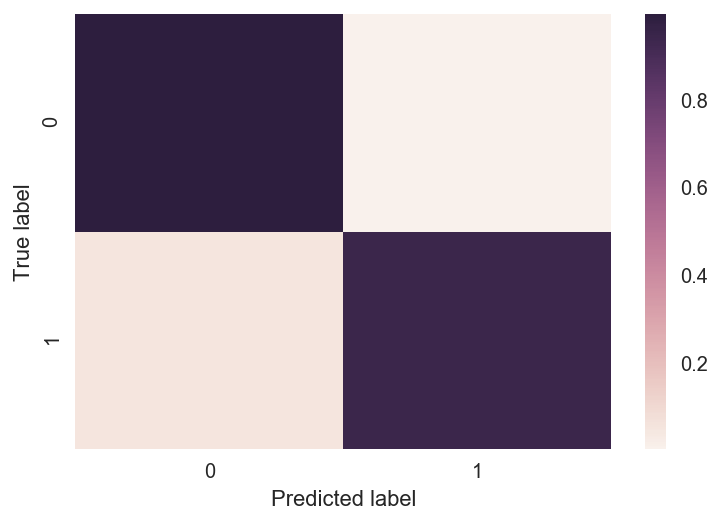

In [116]:
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Future works

In [117]:
print(conf_mat)

[[960   5]
 [  8 142]]


In [118]:
pd.set_option('display.max_colwidth', -1)

#### Misclassified as Spam

In [122]:
X_test[y_test < prediction['Multinomial']]

573     Waiting for your call.                                                                                                      
4727    I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
5475    Dhoni have luck to win some big title.so we will win:)                                                                      
4860    Nokia phone is lovly..                                                                                                      
1259    We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us                           
Name: text, dtype: object

#### Misclassfied as Ham

In [120]:
X_test[y_test > prediction['Multinomial']]

5035    You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt       
2574    Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.   
3130    LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323.
68      Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"                                                                            
2662    Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?                          
4211    Missed call alert. These numbers called but left no message. 07008009200                                                                                    
3572    Yo